Trigger word detection is the technology that allows devices like Amazon Alexa, Google Home, Apple Siri, and Baidu DuerOS to wake up upon hearing a certain word. In this notebook, the trigger word will be "Activate." Every time it hears "activate," it will make a "chiming" sound.

Need to build a network that will ingest a spectrogram and output a signal when it detects the trigger word. This network will use 4 layers: A convolutional layer, Two GRU layers, A dense layer. 

<img src="images/model.png" style="width:600px;height:600px;">

##### 1D convolutional layer
* It inputs the 5511 step spectrogram.  Each step is a vector of 101 units.
* It outputs a 1375 step output
* This output is further processed by multiple layers to get the final $T_y = 1375$ step output. 
* This extracts low-level features and then possibly generating an output of a smaller dimension. 
* Computationally, the 1-D conv layer also helps speed up the model because now the GRU  can process only 1375 timesteps rather than 5511 timesteps. 

##### GRU, dense and sigmoid
* The two GRU layers read the sequence of inputs from left to right.
* A dense plus sigmoid layer makes a prediction for $y^{\langle t \rangle}$. 
* Because $y$ is a binary value (0 or 1), a sigmoid output was used at the last layer to estimate the chance of the output being 1, corresponding to the user having just said "activate."

#### Unidirectional RNN
* Important for trigger word detection to be able to detect the trigger word almost immediately after it is said. 
* With a bidirectional RNN, have to wait for the whole 10sec of audio to be recorded before it can be certain that "activate" was said in the first second of the audio clip.  

In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from twdutils import *
%matplotlib inline

c:\users\srotaswati panda\appdata\local\programs\python\python36\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
IPython.display.Audio("images/example_train.wav")

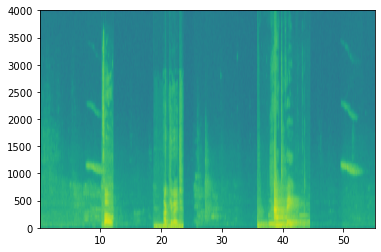

In [3]:
x = graph_spectrogram("images/example_train.wav")

In [4]:
_, data = wavfile.read("images/example_train.wav")
print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", x.shape)

Time steps in audio recording before spectrogram (441000,)
Time steps in input after spectrogram (101, 5511)


In [5]:
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram
Ty = 1375 # The number of time steps in the output

In [6]:
# Load audio segments using pydub 
activates, negatives, backgrounds = load_raw_audio()

print("background len should be 10,000, since it is a 10 sec clip\n" + str(len(backgrounds[0])),"\n")
print("activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) \n" + str(len(activates[0])),"\n")
print("activate[1] len: different `activate` clips can have different lengths\n" + str(len(activates[1])),"\n")

background len should be 10,000, since it is a 10 sec clip
10000 

activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) 
721 

activate[1] len: different `activate` clips can have different lengths
731 



In [7]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [8]:
def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    # Initialize overlap as a "False" flag. 
    overlap = False
    
    # loop over the previous_segments start and end times. Compare start/end times. Set the flag to True if there is an overlap.
    for previous_start, previous_end in previous_segments:
        if segment_start<=previous_end and segment_end>=previous_start:
            overlap = True

    return overlap

In [9]:
def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    # Use helper function to pick a random time segment onto which to insert the new audio clip.
    segment_time = get_random_time_segment(segment_ms)
    
    # Check if the new segment_time overlaps with one of the previous_segments. If so, keep picking new segment_time at random until it doesn't overlap.
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)

    # Append the new segment_time to the list of previous_segments 
    previous_segments.append(segment_time)
    
    # Superpose audio segment and background
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [10]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 following labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    # Add 1 to the correct index in the background label (y)
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < Ty:
            y[0, i] = 1
    
    return y

In [11]:
def create_training_example(background, activates, negatives):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    np.random.seed(1)
    
    background = background - 20 # Make background quieter

    # Initialize y (label vector) of zeros
    y = np.zeros((1, Ty))

    # Initialize segment times as an empty list
    previous_segments = []
    
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    # Loop over randomly selected "activate" clips and insert in background
    for random_activate in random_activates:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_end)

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    # Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    file_handle = background.export("train" + ".wav", format="wav")
    print("File (train.wav) was saved in your directory.")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")
    
    return x, y

File (train.wav) was saved in your directory.


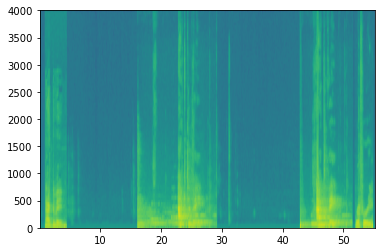

In [12]:
x, y = create_training_example(backgrounds[0], activates, negatives)

In [13]:
IPython.display.Audio("train.wav")

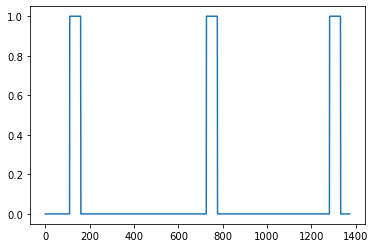

In [14]:
plt.plot(y[0])

In [21]:
# Load preprocessed training examples. 
X = np.load("data/XY_train/X.npy")
Y = np.load("data/XY_train/Y.npy")

In [24]:
# Load preprocessed dev set examples
X_dev = np.load("data/XY_dev/X_dev.npy")
Y_dev = np.load("data/XY_dev/Y_dev.npy")

In [25]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

Using TensorFlow backend.


In [26]:
def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # CONV layer 
    X = Conv1D(filters=196,kernel_size=15,strides=4)(X_input)  # CONV1D
    X = BatchNormalization()(X)                                # Batch normalization
    X = Activation("relu")(X)                                  # ReLu activation
    X = Dropout(rate=0.8)(X)                                   # dropout (use 0.8)

    # First GRU Layer
    X = GRU(units=128, return_sequences = True)(X)             # GRU (use 128 units and return the sequences)
    X = Dropout(rate=0.8)(X)                                   # dropout (use 0.8)
    X = BatchNormalization()(X)                                # Batch normalization
    
    # Second GRU Layer
    X = GRU(units=128, return_sequences = True)(X)             # GRU (use 128 units and return the sequences)
    X = Dropout(rate=0.8)(X)                                   # dropout (use 0.8)
    X = BatchNormalization()(X)                                # Batch normalization
    X = Dropout(rate=0.8)(X)                                   # dropout (use 0.8)
    
    # Time-distributed dense layer (see given code in instructions) 
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X)   # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [27]:
model = model(input_shape = (Tx, n_freq))

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 5511, 101)         0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1375, 256)         388096    
_________________________________________________________________
batch_normalization_7 (Batch (None, 1375, 256)         1024      
_________________________________________________________________
activation_3 (Activation)    (None, 1375, 256)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1375, 256)         0         
_________________________________________________________________
gru_5 (GRU)                  (None, 1375, 128)         147840    
_________________________________________________________________
dropout_8 (Dropout)          (None, 1375, 128)         0         
__________

In [29]:
model = load_model('./models/tr_model.h5')

In [31]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [32]:
model.fit(X, Y, batch_size = 5, epochs=1)

Epoch 1/1
26/26 [==============================] - 8s 324ms/step - loss: 0.0595 - acc: 0.9798


In [33]:
loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

25/25 [==============================] - 2s 66ms/step
Dev set accuracy =  0.9312582015991211


In [34]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

In [35]:
chime_file = "data/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

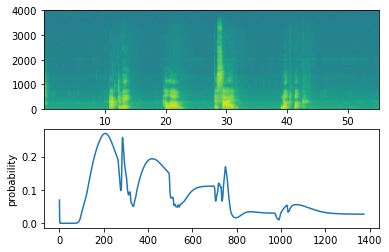

In [38]:
filename = "data/dev/1.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./chime_output.wav")

In [39]:
# Preprocess the audio to the correct format
def preprocess_audio(filename):
    # Trim or pad audio segment to 10000ms
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    # Set frame rate to 44100
    segment = segment.set_frame_rate(44100)
    # Export as wav
    segment.export(filename, format='wav')

In [ ]:
your_filename = "audio_examples/my_audio.wav"

In [ ]:
preprocess_audio(your_filename)
IPython.display.Audio(your_filename)

In [ ]:
chime_threshold = 0.5
prediction = detect_triggerword(your_filename)
chime_on_activate(your_filename, prediction, chime_threshold)
IPython.display.Audio("./chime_output.wav")